In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [75]:
gold_df['risk_score'].dtype

dtype('float64')

In [74]:
gold_df['risk_score'] = pd.to_numeric(gold_df['risk_score'], errors = 'coerce')

In [72]:
gold_df['risk_score'] = gold_df['risk_score'].astype(float)

In [ ]:
--- 442 real patients 
--- age, sex, BMI, blood pressure, 6 blood serum measurements
# Target quantitative measure of disease progression one year after baseline

In [4]:
# RAW - SILVER - GOLD
diabetes_data = load_diabetes()

raw_df = pd.DataFrame(diabetes_data.data, columns = diabetes_data.feature_names)
raw_df['target'] = diabetes_data.target
raw_df['target']

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Name: target, Length: 442, dtype: float64

In [5]:
# EDA 
raw_df.isnull().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

In [6]:
raw_df.duplicated().sum()

0

In [ ]:
# SILVER LAYER - Feature engineering

In [ ]:
s4 - cholesterol ratio
s1 + s2 - s3 = lipid score


In [9]:
silver_df = raw_df.copy()

In [11]:
raw_df['sex'].value_counts()

sex
-0.044642    235
 0.050680    207
Name: count, dtype: int64

In [12]:
feature_description = {
    'age':'Age', 
    'sex': 'Sex (1=male, -1 = female)', 
    'bmi':'Body mass index',
    'bp':'Blood pressure', 
    's1':'Totl.cholesterol', 
    's2': 'LDL', 
    's3': 'HDL',
    's4': 's1/s3',
    's5': 'TGL', 
    's6': 'Blood sugar level'
}

In [14]:
# FEATURE ENGINEERING : domain knowledge + data 
silver_df['cholesterol_ratio'] = silver_df['s4']
silver_df['bmi_bp_interaction'] = silver_df['bmi']*silver_df['bp']
silver_df['age_bmi_risk'] = silver_df['age']*silver_df['bmi']
silver_df['lipid_profile_score'] = silver_df['s1']+silver_df['s2']-silver_df['s3']

In [15]:
silver_df.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target',
       'cholesterol_ratio', 'bmi_bp_interaction', 'age_bmi_risk',
       'lipid_profile_score'],
      dtype='object')

In [16]:
# GOLD LAYER
gold_df = silver_df.copy()

In [17]:
gold_df['progression_category'] = pd.cut(gold_df['target'], 
                                        bins = [0,100,200,400],
                                        labels = ['Low', 'Medium', 'High'])

In [18]:
gold_df['risk_score'] = (gold_df[['bmi', 'bp', 's1', 's4', 's5', 's6']].apply(
    lambda x: (x> x.mean()).sum, axis = 1
))

In [19]:
gold_df['risk_score']

0      <bound method Series.sum of bmi     True\nbp  ...
1      <bound method Series.sum of bmi    False\nbp  ...
2      <bound method Series.sum of bmi     True\nbp  ...
3      <bound method Series.sum of bmi    False\nbp  ...
4      <bound method Series.sum of bmi    False\nbp  ...
                             ...                        
437    <bound method Series.sum of bmi     True\nbp  ...
438    <bound method Series.sum of bmi    False\nbp  ...
439    <bound method Series.sum of bmi    False\nbp  ...
440    <bound method Series.sum of bmi     True\nbp  ...
441    <bound method Series.sum of bmi    False\nbp  ...
Name: risk_score, Length: 442, dtype: object

In [ ]:
#VISUALIZATIONS 

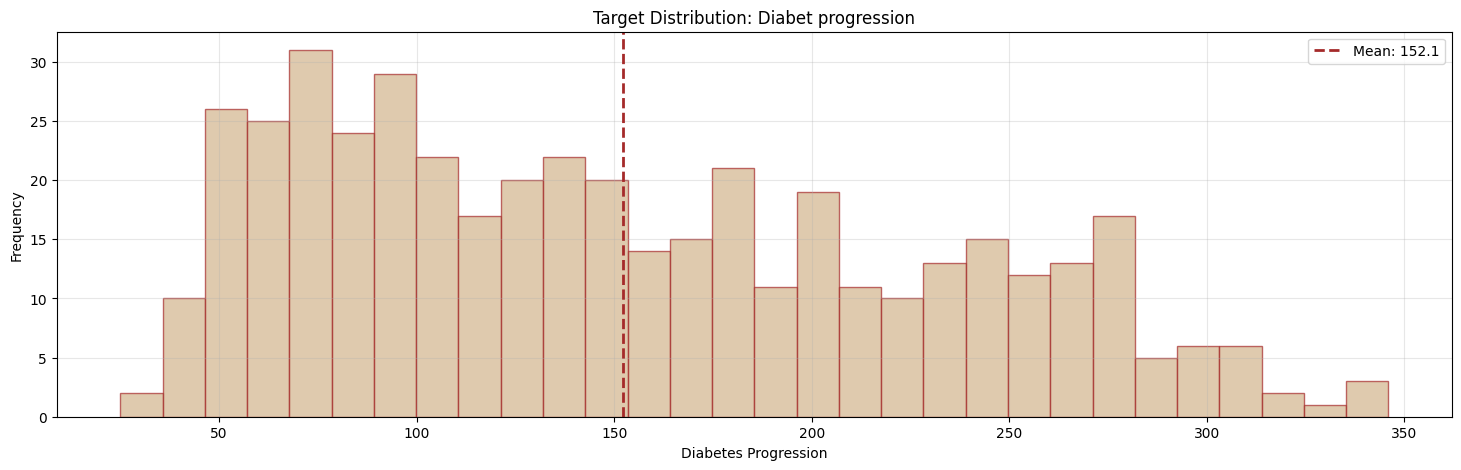

In [28]:
plt.figure(figsize = (18,5))
plt.hist(gold_df['target'], bins = 30, color = 'tan', edgecolor = 'brown', alpha = 0.7)
plt.axvline(gold_df['target'].mean(), color = 'brown', linestyle = '--', linewidth = 2, 
           label = f'Mean: {gold_df["target"].mean():.1f}')
plt.xlabel('Diabetes Progression')
plt.ylabel("Frequency")
plt.title('Target Distribution: Diabet progression')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

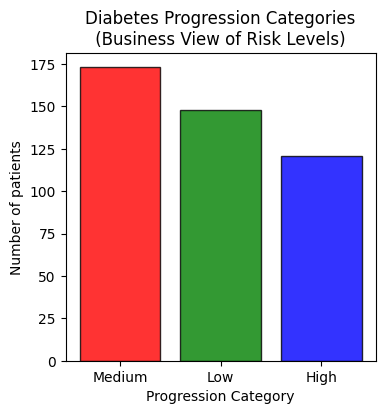

In [33]:
#PROGRESSION CATEGORIES
plt.figure(figsize = (4,4))
progression_counts = gold_df['progression_category'].value_counts()
colors = ['red', 'green', 'blue']
plt.bar(progression_counts.index, progression_counts.values, color = colors, edgecolor='black', alpha= 0.8)
plt.xlabel('Progression Category')
plt.ylabel("Number of patients")
plt.title("Diabetes Progression Categories\n (Business View of Risk Levels) ")
plt.show()

In [34]:
gold_df.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target',
       'cholesterol_ratio', 'bmi_bp_interaction', 'age_bmi_risk',
       'lipid_profile_score', 'progression_category', 'risk_score'],
      dtype='object')

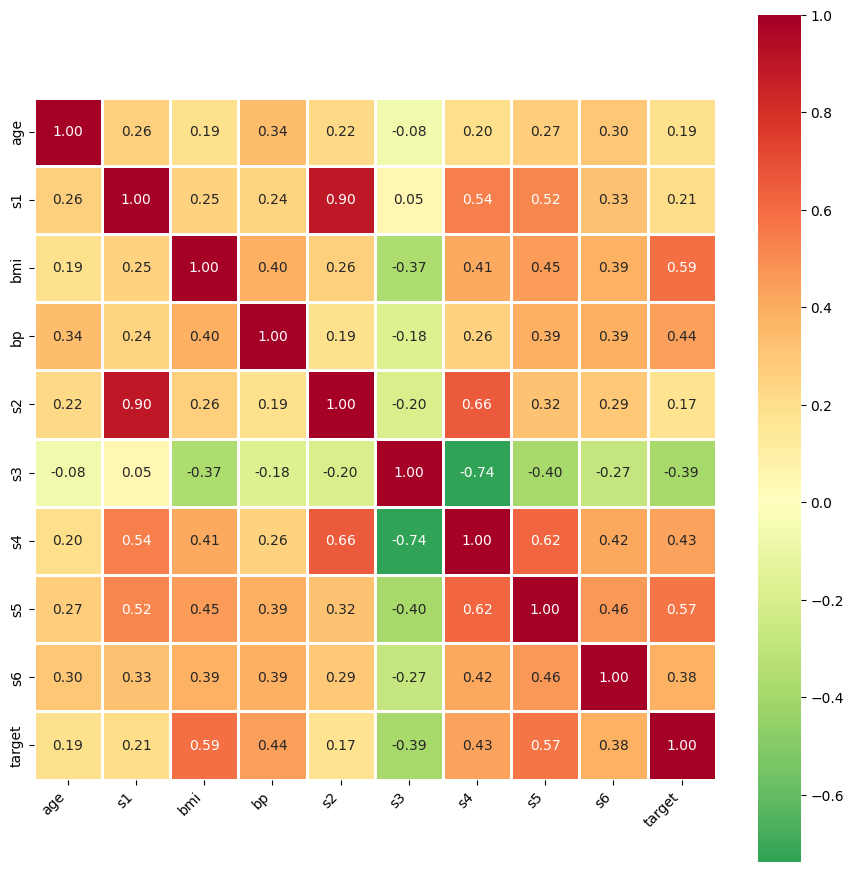

In [39]:
# CORRELATION MATRIX 
plt.figure(figsize = (11,11))
corr_features = ['age', 's1', 'bmi', 'bp', 's2', 's3', 's4', 's5', 's6', 'target']
corr_matrix = gold_df[corr_features].corr()
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'RdYlGn_r', center = 0, 
           square = True, linewidths = 1)
plt.xticks(rotation = 45, ha= 'right')
plt.show()

In [41]:
gold_df.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target',
       'cholesterol_ratio', 'bmi_bp_interaction', 'age_bmi_risk',
       'lipid_profile_score', 'progression_category', 'risk_score'],
      dtype='object')

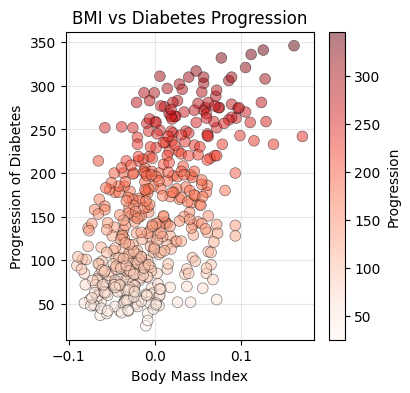

In [49]:
plt.figure(figsize = (4,4))
plt.scatter(gold_df['bmi'], gold_df['target'], alpha= 0.5, c= gold_df['target'], 
           cmap = 'Reds', edgecolors = 'black', linewidth = 0.5, s = 60)
plt.xlabel('Body Mass Index')
plt.ylabel('Progression of Diabetes')
plt.title('BMI vs Diabetes Progression')
plt.colorbar(label = 'Progression')
plt.grid(alpha = 0.3)

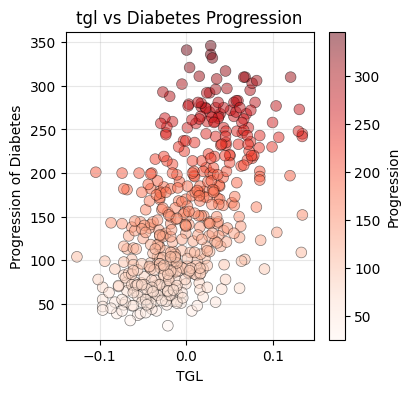

In [50]:
plt.figure(figsize = (4,4))
plt.scatter(gold_df['s5'], gold_df['target'], alpha= 0.5, c= gold_df['target'], 
           cmap = 'Reds', edgecolors = 'black', linewidth = 0.5, s = 60)
plt.xlabel('TGL')
plt.ylabel('Progression of Diabetes')
plt.title('tgl vs Diabetes Progression')
plt.colorbar(label = 'Progression')
plt.grid(alpha = 0.3)

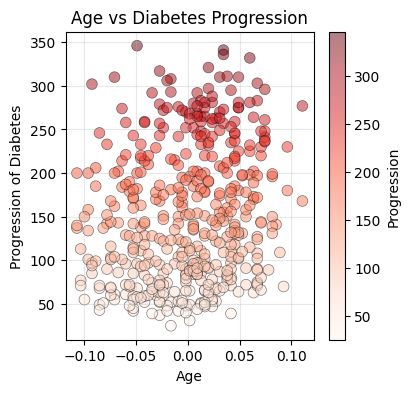

In [51]:
plt.figure(figsize = (4,4))
plt.scatter(gold_df['age'], gold_df['target'], alpha= 0.5, c= gold_df['target'], 
           cmap = 'Reds', edgecolors = 'black', linewidth = 0.5, s = 60)
plt.xlabel('Age')
plt.ylabel('Progression of Diabetes')
plt.title('Age vs Diabetes Progression')
plt.colorbar(label = 'Progression')
plt.grid(alpha = 0.3)

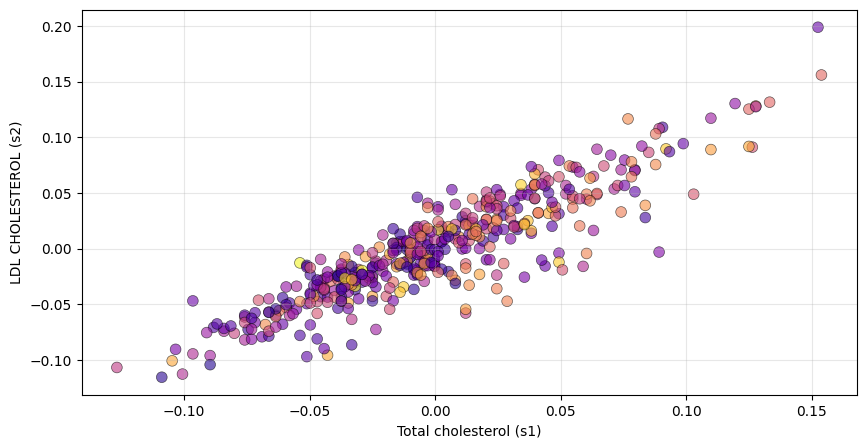

In [56]:
plt.figure(figsize = (10,5))
plt.scatter(gold_df['s1'], gold_df['s2'], c = gold_df['target'], cmap = 'plasma', 
           alpha = 0.6, edgecolors = 'black', linewidth = 0.5, s = 60)
plt.xlabel('Total cholesterol (s1)')
plt.ylabel('LDL CHOLESTEROL (s2)')

plt.grid(alpha = 0.3)

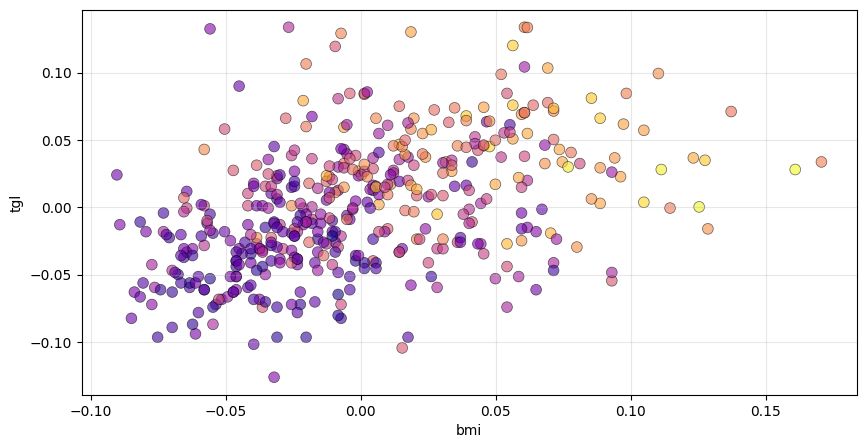

In [58]:
plt.figure(figsize = (10,5))
plt.scatter(gold_df['bmi'], gold_df['s5'], c = gold_df['target'], cmap = 'plasma', 
           alpha = 0.6, edgecolors = 'black', linewidth = 0.5, s = 60)
plt.xlabel('bmi')
plt.ylabel('tgl')

plt.grid(alpha = 0.3)

In [62]:
gold_df['target'].mean()

152.13348416289594

In [63]:
gold_df.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target',
       'cholesterol_ratio', 'bmi_bp_interaction', 'age_bmi_risk',
       'lipid_profile_score', 'progression_category', 'risk_score'],
      dtype='object')

In [64]:
# PREPARE DATA FOR MODEL TRAINING 
feature_cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',  'cholesterol_ratio', 'bmi_bp_interaction', 
               'age_bmi_risk', 'risk_score']

In [65]:
X = gold_df[feature_cols].copy()
y = gold_df['target']

In [66]:
X.isnull().sum()

age                   0
sex                   0
bmi                   0
bp                    0
s1                    0
s2                    0
s3                    0
s4                    0
s5                    0
s6                    0
cholesterol_ratio     0
bmi_bp_interaction    0
age_bmi_risk          0
risk_score            0
dtype: int64

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [70]:
X_train.shape

(353, 14)

In [76]:
rf_model = RandomForestRegressor(n_estimators = 200, max_depth = 10, min_samples_split=5, 
                                random_state=42)


In [77]:
rf_model

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [80]:
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test,rf_pred)
rf_model

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [81]:
from sklearn.ensemble import GradientBoostingRegressor

In [88]:
X_train_scaled

array([[ 1.49836523,  1.06136988,  0.21990201, ..., -0.08847977,
         0.20165607,  0.82051118],
       [-0.22885822,  1.06136988, -0.41936607, ..., -0.12145671,
        -0.10749253, -0.67880614],
       [ 0.08518241, -0.94217861,  1.01898711, ...,  1.58768622,
        -0.06146082,  1.81056598],
       ...,
       [ 0.63475351, -0.94217861, -0.46502808, ..., -0.3159027 ,
        -0.45944505, -0.36079684],
       [-0.30736838, -0.94217861, -0.53352109, ...,  0.01497128,
        -0.0474381 , -0.83256438],
       [-2.03459183, -0.94217861,  0.56236706, ..., -0.5431692 ,
        -1.35207734,  0.11737224]])

In [83]:
gb_model = GradientBoostingRegressor(n_estimators = 150, learning_rate=0.1, max_depth = 4,
                                    random_state = 42)
gb_model.fit(X_train_scaled, y_train)
gb_model
gb_pred = gb_model.predict(X_test_scaled)

In [86]:
rf_r2

0.45384965965926827

In [85]:
gb_r2 = r2_score(y_test, gb_pred)
gb_r2

0.43456696117984717

In [87]:
# RIDGE REGRESSION 
# penalizes large coefficients
# alpha = 1, balances fit and regularization 
# fast training 
# coefficients are interpretable



In [90]:
ridge_model = Ridge(alpha = 1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_pred)

In [91]:
ridge_r2

0.4809754480421109

In [92]:
gold_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target,cholesterol_ratio,bmi_bp_interaction,age_bmi_risk,lipid_profile_score,progression_category,risk_score
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0,-0.002592,0.001349,0.002349,-0.035643,Medium,0.083569
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0,-0.039493,0.001355,0.000097,-0.102024,Low,-0.077802
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0,-0.002592,-0.000252,0.003792,-0.047438,Medium,0.038781
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0,0.034309,0.000425,0.001033,0.073219,High,-0.048251
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0,-0.002592,-0.000796,-0.000196,0.011389,Medium,-0.014512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0,-0.002592,0.001175,0.000820,0.020411,Medium,0.079405
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0,0.034309,0.001076,0.000088,0.157181,Medium,-0.083548
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0,-0.011080,-0.000275,-0.000663,-0.026191,Medium,0.001387
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0,0.026560,0.000047,-0.001776,0.060276,High,0.040277


In [101]:
# DEEP LEARNING - NEURAL NETWORK --- number of parameters
nn_model = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16), 
    activation= 'identity',
    solver = 'adam',
    alpha = 0.001, # L2 REGULARIZATION
    batch_size = 32, 
    max_iter= 1000, 
    early_stopping=True, # STOP IF VALIDATION DOESNT IMPROVE
    validation_fraction=0.1, # 10% of training is for validation
    n_iter_no_change = 1, #PATIENCE BEFORE EARLY STOPPING
    verbose = True
)

In [102]:
nn_model.fit(X_train_scaled, y_train)
nn_pred = nn_model.predict(X_test_scaled)
nn_r2 = r2_score(y_test, nn_pred)

Iteration 1, loss = 15075.75972032
Validation score: -4.022752
Iteration 2, loss = 14878.33104306
Validation score: -3.977988
Iteration 3, loss = 14651.32336718
Validation score: -3.918067
Iteration 4, loss = 14334.65520736
Validation score: -3.843451
Iteration 5, loss = 13846.80305889
Validation score: -3.741854
Iteration 6, loss = 13068.74673650
Validation score: -3.607607
Iteration 7, loss = 12151.97094658
Validation score: -3.482300
Iteration 8, loss = 11001.70766167
Validation score: -3.371836
Iteration 9, loss = 9918.49844047
Validation score: -3.223134
Iteration 10, loss = 8829.59811272
Validation score: -2.817137
Iteration 11, loss = 7596.42057320
Validation score: -2.112538
Iteration 12, loss = 6128.41603246
Validation score: -1.379926
Iteration 13, loss = 4657.41104835
Validation score: -0.593880
Iteration 14, loss = 3228.05354185
Validation score: -0.033437
Iteration 15, loss = 2175.58448089
Validation score: 0.315054
Iteration 16, loss = 1644.56867353
Validation score: 0.48

In [103]:
nn_r2

0.4677548306908087